<a href="https://colab.research.google.com/github/Xuan-He-97/Neural-networks-and-quantum-field-theory/blob/main/Experiments/Chapter3/3_5_NNNGP_Correlations_in_Erf_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pickle
import pathlib
import os
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras import Model
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
from scipy.special import erf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.integrate import quad
from tqdm import tqdm

In [ ]:
from google.colab import drive
# log in to the google drive account
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
Ns = [2, 3, 4, 5, 10, 20, 50, 100, 500, 1000]

In [ ]:
X_erf = np.array([[0.002], [0.004], [0.006], [0.008], [0.010], [0.012]])

### Find all distinct combination of $G^{(n)}$

In [ ]:
def findsubsets(X, n):
    res = []
    for i1 in range(n+1):
        for i2 in range(n+1-i1):
            for i3 in range(n+1-i1-i2):
                for i4 in range(n+1-i1-i2-i3):
                    for i5 in range(n+1-i1-i2-i3-i4):
                        i6 = n-i1-i2-i3-i4-i5
                        res.append([X[0]]*i1 + [X[1]]*i2 + [X[2]]*i3 + [X[3]]*i4 + [X[4]]*i5 + [X[5]]*i6)
    return res

In [ ]:
comb2 = findsubsets([i for i in range(6)], 2)
print(len(comb2))
comb4 = findsubsets([i for i in range(6)], 4)
print(len(comb4))
comb6 = findsubsets([i for i in range(6)], 6)
print(len(comb6))

21
126
462


### $\Delta_{1234y}$

In [ ]:
def integrand4(t, x1, x2, x3, x4, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t)

### $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
def compute_integral4(X, comb, K, Lambda, integrand=integrand4):
    res = []
    for c in comb:
        x1, x2, x3, x4 = X[c]
        res.append(quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, K), epsabs=0)[0])
    return dict(zip([tuple(c) for c in comb], res))

### $\Delta_{1234,y,56}$

In [ ]:
def integrand6(t, x1, x2, x3, x4, x5, x6, K):
    return K(x1, t) * K(x2, t) * K(x3, t) * K(x4, t) * K(x5, x6)

### $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
def compute_integral6(X, comb, K, Lambda, integrand=integrand6):
    res = []
    wick_pairs24 = [[1, 2, 3, 4, 5, 6], [1, 3, 2, 4, 5, 6], [1, 4, 2, 3, 5, 6], [1, 5, 2, 3, 4, 6], [1, 6, 2, 3, 4, 5], 
                    [2, 3, 1, 4, 5, 6], [2, 4, 1, 3, 5, 6], [2, 5, 1, 3, 4, 6], [2, 6, 1, 3, 4, 5], [3, 4, 1, 2, 5, 6], 
                    [3, 5, 1, 2, 4, 6], [3, 6, 1, 2, 4, 5], [4, 5, 1, 2, 3, 6], [4, 6, 1, 2, 3, 5], [5, 6, 1, 2, 3, 4]]
    for c in comb:
        inte = 0
        for idx in wick_pairs24:
            idx = [i-1 for i in idx]
            x1, x2, x3, x4 = X[c][idx[2:]]
            x5, x6 = X[c][idx[:2]]
            inte += quad(integrand, -Lambda, Lambda, args=(x1, x2, x3, x4, x5, x6, K), epsabs=0)[0]
        res.append(inte)
    return dict(zip([tuple(c) for c in comb], res))

## Erf-net

### $K(x_i, x_j)$ and $K_W(x_i, x_j)$

In [ ]:
def K_erf(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((1.0 + 2.0*sigmab2 + 2.0*sigmaw2*xx/d_in) * (1.0 + 2.0*sigmab2 + 2.0*sigmaw2*yy/d_in))
    return sigmab2 + sigmaw2 * (2.0 / np.pi) * np.arcsin(2.0 * (sigmab2 + sigmaw2*xy/d_in) / corr) 

In [ ]:
def Kw_erf(x, y, sigmab2=1.0, sigmaw2=1.0, d_in=1.0):
    xy = x * y
    xx = x * x
    yy = y * y
    corr = np.sqrt((1.0 + 2.0*sigmab2 + 2.0*sigmaw2*xx/d_in) * (1.0 + 2.0*sigmab2 + 2.0*sigmaw2*yy/d_in))
    return sigmaw2 * (2.0 / np.pi) * np.arcsin(2.0 * (sigmab2 + sigmaw2*xy/d_in) / corr) 

### Compute $\int d^{d_{in}}y \; \Delta_{1234y}$

In [ ]:
%%time
integral4_erf = compute_integral4(X_erf.reshape(-1), comb4, Kw_erf, 100)

CPU times: user 1.39 s, sys: 5.02 ms, total: 1.39 s
Wall time: 1.41 s


### Compute $\Sigma\int d^{d_{in}}y \; \Delta_{1234,y,56}$

In [ ]:
%%time
integral6_erf = compute_integral6(X_erf.reshape(-1), comb6, Kw_erf, 100000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  if sys.path[0] == '':


CPU times: user 4min 26s, sys: 619 ms, total: 4min 27s
Wall time: 4min 28s


### Compute $K_W(x_i, x_j)$ and save the results

In [ ]:
def compute_K(X, comb, K):
    K_values = []
    for c in comb:
        x1, x2 = X[c]
        K_values.append(K(x1, x2))
    return dict(zip([tuple(c) for c in comb], K_values))

In [ ]:
K_values = compute_K(X_erf.reshape(-1), comb2, K_erf)

In [ ]:
K_values

{(0, 0): 1.4645598136092999,
 (0, 1): 1.4645598136108184,
 (0, 2): 1.4645582952270801,
 (0, 3): 1.4645552585406818,
 (0, 4): 1.4645507036803678,
 (0, 5): 1.4645446308210177,
 (1, 1): 1.4645620912251445,
 (1, 2): 1.4645628504214168,
 (1, 3): 1.4645620912494377,
 (1, 4): 1.4645598138051614,
 (1, 5): 1.4645560182306856,
 (2, 2): 1.4645658871867675,
 (2, 3): 1.4645674055401394,
 (2, 4): 1.4645674055446938,
 (2, 5): 1.464565887309742,
 (3, 3): 1.4645712013969983,
 (3, 4): 1.4645734788503837,
 (3, 5): 1.4645742379768165,
 (4, 4): 1.4645780337198069,
 (4, 5): 1.4645810701966937,
 (5, 5): 1.4645863839803137}

### Wick contraction

In [ ]:
def G_gp2(X, K):
    x1, x2 = X
    return K(x1, x2)

In [ ]:
def G_gp4(X, K):
    x1, x2, x3, x4 = X
    return K(x1, x2) * K(x3, x4) + K(x1, x3) * K(x2, x4) + K(x1, x4) * K(x2, x3)

In [ ]:
def G_gp6(X, K):
    wick_pairs = [[1, 2, 3, 4, 5, 6], [1, 2, 3, 5, 4, 6], [1, 2, 3, 6, 4, 5], [1, 3, 2, 4, 5, 6], [1, 3, 2, 5, 4, 6],
                  [1, 3, 2, 6, 4, 5], [1, 4, 2, 3, 5, 6], [1, 4, 2, 5, 3, 6], [1, 4, 2, 6, 3, 5], 
                  [1, 5, 2, 3, 4, 6], [1, 5, 2, 4, 3, 6],
                  [1, 5, 2, 6, 3, 4], [1, 6, 2, 3, 4, 5], [1, 6, 2, 4, 3, 5], [1, 6, 2, 5, 3, 4]]
    res = 0
    for x1, x2, x3, x4, x5, x6 in wick_pairs:
        res += K(X[x1-1], X[x2-1]) * K(X[x3-1], X[x4-1]) * K(X[x5-1], X[x6-1])
    return res

### Compute $G_{GP}^{(6)}$

In [ ]:
G_gp6_erf = []
for c in comb6:
    G_gp6_erf.append(G_gp6(X_erf.reshape(-1)[c], K_erf))
G_gp6_erf = dict(zip([tuple(c) for c in comb6], G_gp6_erf))

### Load experimental $G^{(4)}$ and $G^{(6)}$ result and compute $\lambda_m$

In [ ]:
dir = '/gdrive/MyDrive/NNGP/erf/'
files = list(pathlib.Path(dir).glob('*'))
lambdam4_erf = []
lambdam6_erf = []
G4_erf = []
G6_erf = []
for file in tqdm(files):
    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            B = 24 * integral4_erf[tuple(c)]
            G4 = fx_exp[:, c].prod(1).mean()
            lambdam4_erf.append((A - G4) / B)
            G4_erf.append(G4)
        for c in comb6: 
            A = G_gp6_erf[tuple(c)]
            B = 24 * integral6_erf[tuple(c)]
            G6 = fx_exp[:, c].prod(1).mean()
            lambdam6_erf.append((A - G6) / B)
            G6_erf.append(G6)

100%|██████████| 10/10 [43:22<00:00, 260.30s/it]


### Plot $\lambda_{m4}$ 

In [ ]:
lambdam4_erf_df = pd.DataFrame(np.log10(np.abs(lambdam4_erf).reshape(10, -1)))
lambdam4_erf_df.index = np.log10(Ns)

In [ ]:
lambdam4_erf_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
0.301030,-1.015413,-1.015369,-1.015327,-1.015287,-1.015249,-1.015324,-1.015284,-1.015247,-1.015211,-1.015244,-1.015209,-1.015175,-1.015173,-1.015141,-1.015110,-1.015279,-1.015241,-1.015206,-1.015173,-1.015203,-1.015170,-1.015139,-1.015136,-1.015107,-1.015078,-1.015165,-1.015133,-1.015104,-1.015102,-1.015075,-1.015047,-1.015070,-1.015045,-1.015020,-1.014994,-1.015233,-1.015198,-1.015165,-1.015133,-1.015162,...,-1.015004,-1.014983,-1.014962,-1.014941,-1.015051,-1.015026,-1.015004,-1.015001,-1.014981,-1.014960,-1.014975,-1.014957,-1.014938,-1.014919,-1.014949,-1.014933,-1.014916,-1.014899,-1.014881,-1.015016,-1.014993,-1.014973,-1.014970,-1.014952,-1.014933,-1.014946,-1.014930,-1.014914,-1.014896,-1.014922,-1.014908,-1.014894,-1.014879,-1.014863,-1.014898,-1.014886,-1.014873,-1.014861,-1.014847,-1.014833
0.477121,-1.193857,-1.193832,-1.193809,-1.193788,-1.193769,-1.193806,-1.193785,-1.193766,-1.193750,-1.193764,-1.193747,-1.193732,-1.193730,-1.193717,-1.193705,-1.193780,-1.193761,-1.193744,-1.193730,-1.193742,-1.193727,-1.193715,-1.193712,-1.193702,-1.193691,-1.193722,-1.193710,-1.193699,-1.193697,-1.193689,-1.193680,-1.193684,-1.193678,-1.193671,-1.193664,-1.193753,-1.193737,-1.193722,-1.193710,-1.193720,...,-1.193656,-1.193654,-1.193652,-1.193649,-1.193666,-1.193660,-1.193656,-1.193653,-1.193651,-1.193649,-1.193646,-1.193647,-1.193646,-1.193646,-1.193639,-1.193641,-1.193643,-1.193645,-1.193646,-1.193649,-1.193645,-1.193644,-1.193641,-1.193641,-1.193641,-1.193636,-1.193639,-1.193641,-1.193642,-1.193631,-1.193636,-1.193640,-1.193644,-1.193647,-1.193626,-1.193632,-1.193638,-1.193644,-1.193650,-1.193655
0.602060,-1.377515,-1.377456,-1.377400,-1.377345,-1.377293,-1.377397,-1.377343,-1.377291,-1.377240,-1.377288,-1.377238,-1.377190,-1.377187,-1.377141,-1.377095,-1.377338,-1.377285,-1.377235,-1.377187,-1.377233,-1.377185,-1.377139,-1.377136,-1.377093,-1.377048,-1.377180,-1.377134,-1.377090,-1.377087,-1.377046,-1.377004,-1.377041,-1.377001,-1.376961,-1.376921,-1.377278,-1.377228,-1.377180,-1.377134,-1.377177,...,-1.376946,-1.376911,-1.376875,-1.376839,-1.377023,-1.376984,-1.376946,-1.376944,-1.376908,-1.376873,-1.376903,-1.376870,-1.376837,-1.376803,-1.376863,-1.376832,-1.376800,-1.376768,-1.376736,-1.376973,-1.376936,-1.376901,-1.376898,-1.376865,-1.376832,-1.376860,-1.376829,-1.376798,-1.376766,-1.376822,-1.376793,-1.376763,-1.376734,-1.376704,-1.376783,-1.376756,-1.376729,-1.376701,-1.376673,-1.376645
0.698970,-1.464487,-1.464432,-1.464379,-1.464328,-1.464279,-1.464376,-1.464325,-1.464277,-1.464230,-1.464274,-1.464227,-1.464183,-1.464180,-1.464138,-1.464095,-1.464320,-1.464272,-1.464225,-1.464180,-1.464222,-1.464178,-1.464135,-1.464133,-1.464093,-1.464052,-1.464173,-1.464130,-1.464090,-1.464088,-1.464049,-1.464011,-1.464044,-1.464008,-1.463972,-1.463935,-1.464264,-1.464217,-1.464173,-1.464130,-1.464170,...,-1.463957,-1.463925,-1.463893,-1.463860,-1.464027,-1.463991,-1.463957,-1.463955,-1.463923,-1.463890,-1.463918,-1.463888,-1.463858,-1.463827,-1.463880,-1.463853,-1.463825,-1.463796,-1.463767,-1.463981,-1.463947,-1.463915,-1.463913,-1.463883,-1.463853,-1.463878,-1.463850,-1.463822,-1.463794,-1.463843,-1.463817,-1.463791,-1.463765,-1.463738,-1.463807,-1.463784,-1.463760,-1.463736,-1.463711,-1.463686
1.000000,-1.840666,-1.840726,-1.840789,-1.840853,-1.840920,-1.840786,-1.840851,-1.840918,-1.840986,-1.840915,-1.840984,-1.841055,-1.841053,-1.841126,-1.841198,-1.840846,-1.840913,-1.840982,-1.841053,-1.840979,-1.841050,-1.841123,-1.841121,-1.841196,-1.841271,-1.841046,-1.841119,-1.841194,-1.841191,-1.841269,-1.841346,-1.841264,-1.841343,-1.841422,-1.841501,-1.840906,-1.840975,-1.841046,-1.841119,-1.841043,...,-1.841408,-1.841492,-1.841575,-1.841658,-1.841247,-1.841327,-1.841408,-1.8

In [ ]:
X_erf.reshape(-1)[comb4[25]]

array([0.006, 0.006, 0.012, 0.012])

In [ ]:
X_erf.reshape(-1)[comb4[61]]

array([0.004, 0.004, 0.006, 0.012])

In [ ]:
X_erf.reshape(-1)[[0, 0, 4, 4]]

array([0.002, 0.002, 0.01 , 0.01 ])

In [ ]:
X_erf.reshape(-1)[comb4[89]]

array([0.002, 0.006, 0.006, 0.006])

In [ ]:
X_erf.reshape(-1)[comb4[115]]

array([0.002, 0.002, 0.004, 0.012])

In [ ]:
X_erf.reshape(-1)[comb4[125]]

array([0.002, 0.002, 0.002, 0.002])

In [ ]:
X_erf

array([[0.002],
       [0.004],
       [0.006],
       [0.008],
       [0.01 ],
       [0.012]])

In [ ]:
x1, x2, x3, x4 = 0.002, 0.002, 0.01 , 0.01
Lambda = np.inf
quad(integrand4, -Lambda, Lambda, args=(x1, x2, x3, x4, Kw_erf), epsabs=0)

(0.08143004297590549, 8.506023663201745e-11)

In [ ]:
x1, x2, x3, x4 = 0.008, 0.002, 0.004, 0.012
Lambda = 100000
quad(integrand4, -Lambda, Lambda, args=(x1, x2, x3, x4, Kw_erf))

(0.08144530875609339, 3.305043125300961e-09)

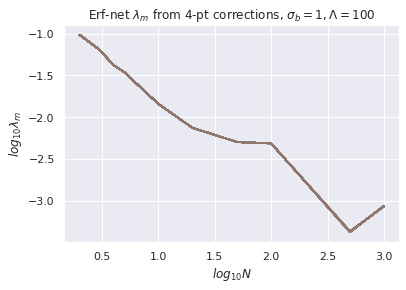

In [ ]:
ax = lambdam4_erf_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("Erf-net $\lambda_m$ from 4-pt corrections, $\sigma_b=1, \Lambda=100$")
plt.show()

### Plot $\lambda_{m6}$ 

In [ ]:
lambdam6_erf_df = pd.DataFrame(np.log10(np.abs(lambdam6_erf).reshape(10, -1)))
lambdam6_erf_df.index = np.log10(Ns)

In [ ]:
lambdam6_erf_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461
0.301030,-0.519417,-0.519211,-0.519025,-0.518856,-0.518702,-0.518563,-0.518438,-0.519005,-0.518837,-0.518685,-0.518548,-0.518424,-0.518312,-0.518669,-0.518533,-0.518410,-0.518299,-0.518199,-0.518396,-0.518286,-0.518187,-0.518098,-0.518175,-0.518088,-0.518008,-0.517999,-0.517929,-0.517858,-0.518798,-0.518649,-0.518515,-0.518393,-0.518283,-0.518185,-0.518500,-0.518379,-0.518271,-0.518173,-0.518085,-0.518258,...,-0.517414,-0.517404,-0.517393,-0.517381,-0.517438,-0.517424,-0.517413,-0.517410,-0.517400,-0.517390,-0.517396,-0.517387,-0.517379,-0.517369,-0.517380,-0.517374,-0.517367,-0.517359,-0.517350,-0.517411,-0.517400,-0.517391,-0.517389,-0.517381,-0.517373,-0.517377,-0.517371,-0.517364,-0.517356,-0.517364,-0.517359,-0.517354,-0.517348,-0.517341,-0.517351,-0.517347,-0.517343,-0.517339,-0.517333,-0.517327
0.477121,-0.708995,-0.708800,-0.708624,-0.708464,-0.708321,-0.708192,-0.708076,-0.708604,-0.708446,-0.708304,-0.708177,-0.708062,-0.707960,-0.708288,-0.708161,-0.708048,-0.707947,-0.707857,-0.708034,-0.707935,-0.707846,-0.707766,-0.707834,-0.707756,-0.707687,-0.707677,-0.707617,-0.707556,-0.708407,-0.708268,-0.708143,-0.708032,-0.707932,-0.707843,-0.708128,-0.708018,-0.707919,-0.707832,-0.707754,-0.707907,...,-0.707201,-0.707200,-0.707199,-0.707197,-0.707205,-0.707202,-0.707200,-0.707197,-0.707197,-0.707196,-0.707192,-0.707194,-0.707195,-0.707195,-0.707187,-0.707190,-0.707192,-0.707194,-0.707195,-0.707188,-0.707187,-0.707188,-0.707186,-0.707188,-0.707189,-0.707183,-0.707187,-0.707189,-0.707191,-0.707180,-0.707185,-0.707189,-0.707193,-0.707196,-0.707177,-0.707183,-0.707189,-0.707194,-0.707198,-0.707202
0.602060,-0.871729,-0.871519,-0.871328,-0.871154,-0.870996,-0.870852,-0.870722,-0.871308,-0.871136,-0.870979,-0.870837,-0.870708,-0.870592,-0.870963,-0.870822,-0.870694,-0.870579,-0.870474,-0.870680,-0.870566,-0.870463,-0.870369,-0.870451,-0.870358,-0.870275,-0.870265,-0.870190,-0.870115,-0.871097,-0.870943,-0.870804,-0.870678,-0.870563,-0.870460,-0.870789,-0.870664,-0.870551,-0.870449,-0.870356,-0.870538,...,-0.869630,-0.869615,-0.869599,-0.869583,-0.869663,-0.869645,-0.869629,-0.869626,-0.869612,-0.869596,-0.869607,-0.869594,-0.869580,-0.869566,-0.869587,-0.869576,-0.869564,-0.869551,-0.869538,-0.869632,-0.869616,-0.869602,-0.869600,-0.869588,-0.869575,-0.869584,-0.869573,-0.869561,-0.869549,-0.869566,-0.869557,-0.869546,-0.869536,-0.869524,-0.869548,-0.869540,-0.869531,-0.869522,-0.869512,-0.869501
0.698970,-0.944381,-0.944168,-0.943973,-0.943795,-0.943633,-0.943486,-0.943352,-0.943953,-0.943777,-0.943616,-0.943470,-0.943338,-0.943217,-0.943600,-0.943455,-0.943324,-0.943204,-0.943096,-0.943310,-0.943191,-0.943084,-0.942987,-0.943072,-0.942976,-0.942888,-0.942879,-0.942800,-0.942721,-0.943738,-0.943580,-0.943437,-0.943307,-0.943189,-0.943082,-0.943422,-0.943293,-0.943176,-0.943070,-0.942974,-0.943164,...,-0.942200,-0.942181,-0.942161,-0.942141,-0.942241,-0.942219,-0.942199,-0.942197,-0.942178,-0.942159,-0.942173,-0.942156,-0.942139,-0.942120,-0.942149,-0.942134,-0.942118,-0.942101,-0.942084,-0.942206,-0.942187,-0.942169,-0.942166,-0.942150,-0.942133,-0.942146,-0.942131,-0.942115,-0.942099,-0.942124,-0.942111,-0.942097,-0.942082,-0.942066,-0.942102,-0.942090,-0.942078,-0.942064,-0.942050,-0.942035
1.000000,-1.285373,-1.285213,-1.285070,-1.284946,-1.284837,-1.284742,-1.284661,-1.285051,-1.284928,-1.284820,-1.284727,-1.284647,-1.284580,-1.284804,-1.284712,-1.284633,-1.284567,-1.284511,-1.284620,-1.284554,-1.284500,-1.284455,-1.284488,-1.284445,-1.284410,-1.284400,-1.284374,-1.284348,-1.284889,-1.284784,-1.284694,-1.284617,-1.284552,-1.284497,-1.284679,-1.284603,-1.284539,-1.284486,-1.284442,-1.284527,...,-1.284304,-1.284338,-1.284371,-1.284404,-1.284241,-1.284271,

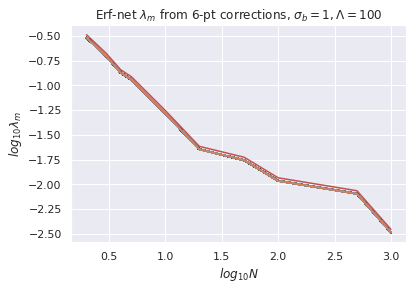

In [ ]:
ax = lambdam6_erf_df.plot(legend=False)
plt.xlabel("$log_{10}N$")
plt.ylabel("$log_{10}\lambda_m$")
plt.title("Erf-net $\lambda_m$ from 6-pt corrections, $\sigma_b=1, \Lambda=100$")
plt.show()

### 6-pt Deviation 

In [ ]:
N = 5

In [ ]:
file = pathlib.Path('/gdrive/MyDrive/NNGP/erf/fx_exp_' + str(N) + '.pickle')
lambdam4_erf_dev = []
lambdam6_erf_dev = []
G4_erf_dev = []
G6_erf_dev = []
Lambda_list = [10, 100, 1000, 10000]
for Lambda in tqdm(Lambda_list):
    integral4_erf = compute_integral4(X_erf.reshape(-1), comb4, Kw_erf, Lambda)
    integral6_erf = compute_integral6(X_erf.reshape(-1), comb6, Kw_erf, Lambda)

    with open(file, 'rb') as handle:
        fx_exp = pickle.load(handle).reshape(10000000, 6)
        for c in comb4: 
            A = K_values[(c[0], c[1])]*K_values[(c[2], c[3])] + K_values[(c[0], c[2])]*K_values[(c[1], c[3])] + K_values[(c[0], c[3])]*K_values[(c[1], c[2])]
            G4 = fx_exp[:, c].prod(1).mean()
            B = 24 * integral4_erf[tuple(c)]
            lambdam4_erf_dev.append((A - G4) / B)
            G4_erf_dev.append(G4)
        for c in comb6: 
            A = G_gp6_erf[tuple(c)]
            B = 24 * integral6_erf[tuple(c)]
            G6 = fx_exp[:, c].prod(1).mean()
            lambdam6_erf_dev.append((A - G6) / B)
            G6_erf_dev.append(G6)

100%|██████████| 4/4 [25:52<00:00, 388.18s/it]


Prediction of GP 6-pt function and GP + $\bar{\lambda}$ correction of 6-pt function. Normalized by experimental $G^{(n)}$ function.

In [ ]:
GP_pred = np.array(list(G_gp6_erf.values())) / np.array(G6_erf_dev).reshape(4, -1)

In [ ]:
GP_lambda_pred_list = []
for i, Lambda in enumerate(Lambda_list):
    integral6_erf = compute_integral6(X_erf.reshape(-1), comb6, Kw_erf, Lambda)
    GP_lambda_pred = (np.array(list(G_gp6_erf.values())) - 24 * np.array(lambdam4_erf_dev).reshape(4, -1).mean(1)[i] * np.array(list(integral6_erf.values()))) / np.array(G6_erf_dev).reshape(4, -1)[i, :]
    GP_lambda_pred_list.append(GP_lambda_pred)

In [ ]:
GP_pred_df = pd.DataFrame(GP_pred, columns=[r"$G^{(6)}_{GP}$/$G^{(6)}$"]*GP_pred.shape[-1])
GP_lambda_pred_df = pd.DataFrame(np.array(GP_lambda_pred_list), 
                        columns=[r"($G^{(6)}_{GP} + \bar{\lambda}$ contribution)/$G^{(6)}$"]*GP_lambda_pred.shape[-1])

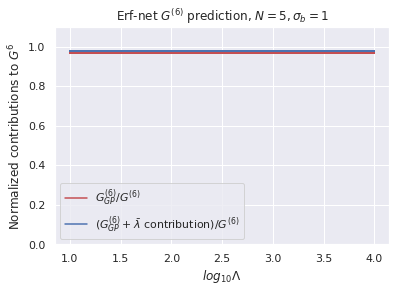

In [ ]:
colors = ['r']*GP_pred.shape[-1] + ['b']*GP_pred.shape[-1]
concated_df = pd.concat([GP_pred_df, GP_lambda_pred_df], axis=1)
concated_df.index = np.log10(Lambda_list)
ax = concated_df.plot(color=colors, legend=False)
lines, labels = ax.get_legend_handles_labels()
ax.legend([lines[0], lines[-1]], [labels[0], labels[-1]], loc='best')
ax.set_ylim([0.0, 1.1])
plt.xlabel("$log_{10}\Lambda$")
plt.ylabel("Normalized contributions to $G^6$")
plt.title("Erf-net $G^{(6)}$ prediction, $N=5, \sigma_b=1$")
plt.show()